# Install libraries

In [1]:
!pip install tensorflow==1.13.1
!pip uninstall -y tensorflow
!pip uninstall -y tensorflow-gpu
!pip install tensorflow-gpu==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0
!pip install imgaug
!pip install Cython
!pip install pycocotools
!pip install kaggle
!pip install imagecodecs

     |████████████████████████████████| 92.6 MB 41 kB/s 
     |████████████████████████████████| 367 kB 52.7 MB/s 
     |████████████████████████████████| 3.2 MB 43.0 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you 

# Clone Repo

In [2]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 38.59 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [15]:
import os 
!pwd
os.chdir('/content/Mask_RCNN')
import sys
import json
import datetime
import numpy as np
import skimage.io
from imgaug import augmenters as iaa
from skimage.io import imread, imsave

# Import Mask RCNN
# sys.path.append('Mask_RCNN')  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize

import itertools
import math
import logging
import re
import random
import time
import concurrent.futures
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon



/content/Mask_RCNN


In [4]:
# Upload the dataset directory to google drive and then mount the drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [16]:
DATASET_DIR = '/content/drive/MyDrive/dataset'


In [17]:

# Path to trained weights file
COCO_WEIGHTS_PATH = "/content/drive/MyDrive/mask_rcnn_nucleus_0039.h5"
# COCO_WEIGHTS_PATH = "/content/drive/MyDrive/mask_rcnn_.h5"

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = "/content/Mask_RCNN/results/logs"

# Results directory
# Save submission files here
RESULTS_DIR = "/content/Mask_RCNN/results/nucleus/"

# The dataset doesn't have a standard train/val split, so I picked
# a variety of images to surve as a validation set.
# VAL_IMAGE_IDS = ['1-1_dVenus_0201_20', '1-1_dVenus_0201_21']
VAL_IMAGE_IDS = ['1-1_dVenus_0201_1', '1-1_dVenus_0201_12', '1-1_dVenus_0201_13', '1-1_dVenus_0201_14', '1-1_dVenus_0201_2', '1-1_dVenus_0201_20', '1-1_dVenus_0201_21', '1-1_dVenus_0201_27', '1-1_dVenus_0201_4', '1-1_dVenus_0201_5', '1-1_dVenus_0201_7', '1-1_dVenus_0206_1', '1-1_dVenus_0206_11', '1-1_dVenus_0206_12', '1-1_dVenus_0206_13', '1-1_dVenus_0206_14', '1-1_dVenus_0206_2', '1-1_dVenus_0206_20', '1-1_dVenus_0206_21', '1-1_dVenus_0206_27', '1-1_dVenus_0206_4', '1-1_dVenus_0206_5', '1-1_dVenus_0206_7', '1-1_dVenus_0206_8', '2-1_dVenus_0204_1', '2-1_dVenus_0204_11', '2-1_dVenus_0204_12', '2-1_dVenus_0204_14', '2-1_dVenus_0204_19', '2-1_dVenus_0204_2', '2-1_dVenus_0204_20', '2-1_dVenus_0204_23', '2-1_dVenus_0204_27', '2-1_dVenus_0204_4', '2-1_dVenus_0204_5', '2-1_dVenus_0204_7', '2-1_dVenus_0204_8', '2-1_dVenus_0204_9', '3-2_dVenus_0306_12', '3-2_dVenus_0306_29', '3-2_dVenus_0306_33', '3-2_dVenus_0306_36', '3-2_dVenus_0306_40', '3-2_dVenus_0306_5', '3-2_dVenus_0408_16', '3-2_dVenus_0408_17', '3-2_dVenus_0408_25', '3-2_dVenus_0408_32', '3-2_dVenus_0408_33', '3-2_dVenus_0408_49', '3-2_dVenus_0408_54', '3-2_dVenus_0408_9']


############################################################
#  Configurations
############################################################

class NucleusConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "nucleus"

    # Adjust depending on your GPU memory
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = 339 
    VALIDATION_STEPS = 52 

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    # IMAGE_MIN_SCALE = 0

    # Length of square anchor side in pixels
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    # MEAN_PIXEL = np.array([43.53, 39.56, 48.22])
    MEAN_PIXEL = np.array([37.63, 37.63, 37.63])
    # MEAN_PIXEL = np.array([17., 17., 17.])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = False
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 120

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 120

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 50


class NucleusInferenceConfig(NucleusConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    # IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7
    DETECTION_MIN_CONFIDENCE = 0.78


############################################################
#  Dataset
############################################################

class NucleusDataset(utils.Dataset):

    def load_nucleus(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("nucleus", 1, "nucleus")

        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val"]
        # subset_dir = "./data/image" if subset in ["train", "val"] else subset
        dataset_dir = os.path.join(dataset_dir, subset)
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            # Get image ids from directory names
            print(dataset_dir)
            print(list(os.walk(dataset_dir)))
            image_ids = next(os.walk(dataset_dir))[1]
            if subset == "train":
                image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))

        # Add images
        for image_id in image_ids:
            self.add_image(
                "nucleus",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "image/{}.tif".format(image_id)))
            im = path=os.path.join(dataset_dir, image_id, "image/{}.tif".format(image_id))
            img = imread(im)
            # imsave("{}/{}.png".format("C:/Users/gisel/Documents/cell_classification_for_tissue_clearing/Mask_RCNN/im",image_id), img)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "mask")
        # print(mask_dir)
        # Read mask files from .png image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            # print(f)
            if f.endswith(".png"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(bool)
                # print(m.shape)
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nucleus":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image//2**8)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image


############################################################
#  Training
############################################################

def train(model, dataset_dir, subset):
    """Train the model."""
    # Training dataset.
    dataset_train = NucleusDataset()
    dataset_train.load_nucleus(dataset_dir, subset)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = NucleusDataset()
    dataset_val.load_nucleus(dataset_dir, "val")
    dataset_val.prepare()

    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])

    # *** This training schedule is an example. Update to your needs ***

    # If starting from imagenet, train heads only for a bit
    # since they have random weights
    # print("Train network heads")
    # model.train(dataset_train, dataset_val,
    #             learning_rate=0.001,
    #             epochs=15,
    #             augmentation=None,
    #             layers='heads')

    print("Train all layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=40,
                augmentation=augmentation,
                layers='all')


############################################################
#  RLE Encoding
############################################################

def rle_encode(mask):
    """Encodes a mask in Run Length Encoding (RLE).
    Returns a string of space-separated values.
    """
    assert mask.ndim == 2, "Mask must be of shape [Height, Width]"
    # Flatten it column wise
    m = mask.T.flatten()
    # Compute gradient. Equals 1 or -1 at transition points
    g = np.diff(np.concatenate([[0], m, [0]]), n=1)
    # 1-based indicies of transition points (where gradient != 0)
    rle = np.where(g != 0)[0].reshape([-1, 2]) + 1
    # Convert second index in each pair to lenth
    rle[:, 1] = rle[:, 1] - rle[:, 0]
    return " ".join(map(str, rle.flatten()))


def rle_decode(rle, shape):
    """Decodes an RLE encoded list of space separated
    numbers and returns a binary mask."""
    rle = list(map(int, rle.split()))
    rle = np.array(rle, dtype=np.int32).reshape([-1, 2])
    rle[:, 1] += rle[:, 0]
    rle -= 1
    mask = np.zeros([shape[0] * shape[1]], np.bool)
    for s, e in rle:
        assert 0 <= s < mask.shape[0]
        assert 1 <= e <= mask.shape[0], "shape: {}  s {}  e {}".format(shape, s, e)
        mask[s:e] = 1
    # Reshape and transpose
    mask = mask.reshape([shape[1], shape[0]]).T
    return mask


def mask_to_rle(image_id, mask, scores):
    "Encodes instance masks to submission format."
    assert mask.ndim == 3, "Mask must be [H, W, count]"
    # If mask is empty, return line with image ID only
    if mask.shape[-1] == 0:
        return "{},".format(image_id)
    # Remove mask overlaps
    # Multiply each instance mask by its score order
    # then take the maximum across the last dimension
    order = np.argsort(scores)[::-1] + 1  # 1-based descending
    mask = np.max(mask * np.reshape(order, [1, 1, -1]), -1)
    # Loop over instance masks
    lines = []
    for o in order:
        m = np.where(mask == o, 1, 0)
        # Skip if empty
        if m.sum() == 0.0:
            continue
        rle = rle_encode(m)
        lines.append("{}, {}".format(image_id, rle))
    return "\n".join(lines)


############################################################
#  Detection
############################################################

def detect(model, dataset_dir, subset):
    """Run detection on images in the given directory."""
    print("Running on {}".format(dataset_dir))

    # Create directory
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
    submit_dir = "submit_{:%Y%m%dT%H%M%S}".format(datetime.datetime.now())
    submit_dir = os.path.join(RESULTS_DIR, submit_dir)
    os.makedirs(submit_dir)

    # Read dataset
    dataset = NucleusDataset()
    dataset.load_nucleus(dataset_dir, subset)
    dataset.prepare()
    # Load over images
    submission = []
    for image_id in dataset.image_ids:
        # Load image and run detection
        image = dataset.load_image(image_id)
        # Detect objects
        r = model.detect([image], verbose=0)[0]
        # Encode image to RLE. Returns a string of multiple lines
        source_id = dataset.image_info[image_id]["id"]
        rle = mask_to_rle(source_id, r["masks"], r["scores"])
        submission.append(rle)
        # Save image with masks
        visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            dataset.class_names, r['scores'],
            show_bbox=False, show_mask=False,
            title="Predictions")
        plt.savefig("{}/{}.png".format(submit_dir, dataset.image_info[image_id]["id"]))

    # Save to csv file
    submission = "ImageId,EncodedPixels\n" + "\n".join(submission)
    file_path = os.path.join(submit_dir, "submit.csv")
    with open(file_path, "w") as f:
        f.write(submission)
    print("Saved to ", submit_dir)



## Prepare the dataset

In [18]:
dataset = NucleusDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
dataset.load_nucleus(DATASET_DIR, subset="train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

/content/drive/MyDrive/dataset/train
[('/content/drive/MyDrive/dataset/train', ['3-2_dVenus_0402_39', '3-2_dVenus_0402_31', '3-2_dVenus_0402_54', '3-2_dVenus_0402_33', '3-2_dVenus_0402_25', '3-2_dVenus_0402_32', '3-2_dVenus_0402_40', '3-2_dVenus_0402_46', '3-2_dVenus_0300_26', '3-2_dVenus_0300_27', '3-2_dVenus_0300_33', '3-2_dVenus_0300_5', '3-2_dVenus_0300_20', '3-2_dVenus_0300_41', '3-2_dVenus_0300_34', '3-2_dVenus_0300_29', '3-2_dVenus_0300_36', '3-2_dVenus_0300_40', '3-2_dVenus_0204_2', '3-2_dVenus_0204_7', '3-2_dVenus_0204_34', '3-2_dVenus_0204_8', '3-2_dVenus_0204_25', '3-2_dVenus_0204_15', '3-2_dVenus_0204_21', '3-2_dVenus_0204_22', '3-2_dVenus_0300_12', '3-2_dVenus_0300_19', '2-1_dVenus_0404_7', '2-1_dVenus_0506_34', '2-1_dVenus_0506_15', '2-1_dVenus_0404_8', '3-2_dVenus_0204_14', '2-1_dVenus_0602_48', '2-1_dVenus_0602_41', '2-1_dVenus_0506_19', '3-2_dVenus_0204_1', '2-1_dVenus_0506_22', '2-1_dVenus_0404_40', '2-1_dVenus_0404_1', '2-1_dVenus_0404_33', '2-1_dVenus_0308_46', '2-1

## Train the model

In [ ]:
config = NucleusConfig()
model = modellib.MaskRCNN(mode="training", config=NucleusConfig(), model_dir=DEFAULT_LOGS_DIR)
# weights_path =  "/content/drive/MyDrive/mask_rcnn_nucleus_0012.h5"
weights_path = model.find_last()
# Download weights file
# if not os.path.exists(weights_path):
#     utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

train(model, DATASET_DIR, "train")



Re-starting from epoch 14
/content/drive/MyDrive/dataset/train
[('/content/drive/MyDrive/dataset/train', ['3-2_dVenus_0402_39', '3-2_dVenus_0402_31', '3-2_dVenus_0402_54', '3-2_dVenus_0402_33', '3-2_dVenus_0402_25', '3-2_dVenus_0402_32', '3-2_dVenus_0402_40', '3-2_dVenus_0402_46', '3-2_dVenus_0300_26', '3-2_dVenus_0300_27', '3-2_dVenus_0300_33', '3-2_dVenus_0300_5', '3-2_dVenus_0300_20', '3-2_dVenus_0300_41', '3-2_dVenus_0300_34', '3-2_dVenus_0300_29', '3-2_dVenus_0300_36', '3-2_dVenus_0300_40', '3-2_dVenus_0204_2', '3-2_dVenus_0204_7', '3-2_dVenus_0204_34', '3-2_dVenus_0204_8', '3-2_dVenus_0204_25', '3-2_dVenus_0204_15', '3-2_dVenus_0204_21', '3-2_dVenus_0204_22', '3-2_dVenus_0300_12', '3-2_dVenus_0300_19', '2-1_dVenus_0404_7', '2-1_dVenus_0506_34', '2-1_dVenus_0506_15', '2-1_dVenus_0404_8', '3-2_dVenus_0204_14', '2-1_dVenus_0602_48', '2-1_dVenus_0602_41', '2-1_dVenus_0506_19', '3-2_dVenus_0204_1', '2-1_dVenus_0506_22', '2-1_dVenus_0404_40', '2-1_dVenus_0404_1', '2-1_dVenus_0404_33', 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 15/40
338/339 [============================>.] - ETA: 0s - loss: 8.7893 - rpn_class_loss: 0.1711 - rpn_bbox_loss: 7.8736 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.3709 - mrcnn_mask_loss: 0.3511

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


339/339 [==============================] - 491s - loss: 8.8967 - rpn_class_loss: 0.1726 - rpn_bbox_loss: 7.9803 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.3707 - mrcnn_mask_loss: 0.3506 - val_loss: 19.7938 - val_rpn_class_loss: 0.3009 - val_rpn_bbox_loss: 18.4219 - val_mrcnn_class_loss: 0.0201 - val_mrcnn_bbox_loss: 0.5748 - val_mrcnn_mask_loss: 0.4762
Epoch 16/40
339/339 [==============================] - 300s - loss: 7.2861 - rpn_class_loss: 0.1395 - rpn_bbox_loss: 6.5191 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.3051 - mrcnn_mask_loss: 0.3043 - val_loss: 18.3720 - val_rpn_class_loss: 0.3415 - val_rpn_bbox_loss: 16.9311 - val_mrcnn_class_loss: 0.0161 - val_mrcnn_bbox_loss: 0.5945 - val_mrcnn_mask_loss: 0.4887
Epoch 17/40
339/339 [==============================] - 300s - loss: 6.8366 - rpn_class_loss: 0.1255 - rpn_bbox_loss: 6.1419 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2673 - mrcnn_mask_loss: 0.2845 - val_loss: 18.0060 - val_rpn_class_loss: 0.3982 - val_rpn_bbox_l

In [12]:
from google.colab import files

files.download(model.find_last())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Perform detection

In [ ]:
import matplotlib.pyplot as plt
model_inf = modellib.MaskRCNN(
    mode="inference",
    config=NucleusInferenceConfig(),
    model_dir=DEFAULT_LOGS_DIR
)
weights_path = model_inf.find_last()
model_inf.load_weights(weights_path, by_name=True)

detect(model_inf, DATASET_DIR, "val")

## Inspect predictions

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image ID: nucleus.1-1_dVenus_0309_24 (227) 1-1_dVenus_0309_24
Original image shape:  [224 224   3]
(256, 256, 3)
Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:   74.00000  uint16
molded_images            shape: (1, 256, 256, 3)      min:    3.00000  max:   74.00000  uint16
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   10.00000  max:   97.00000  int32
gt_mask                  shape: (256, 256, 2)         min:    0.00000  max:    1.00000  bool
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 0.500
AP @0.90:	 0.500
AP @0.95:	 0.500
AP @0.50-0.95:	 0.850


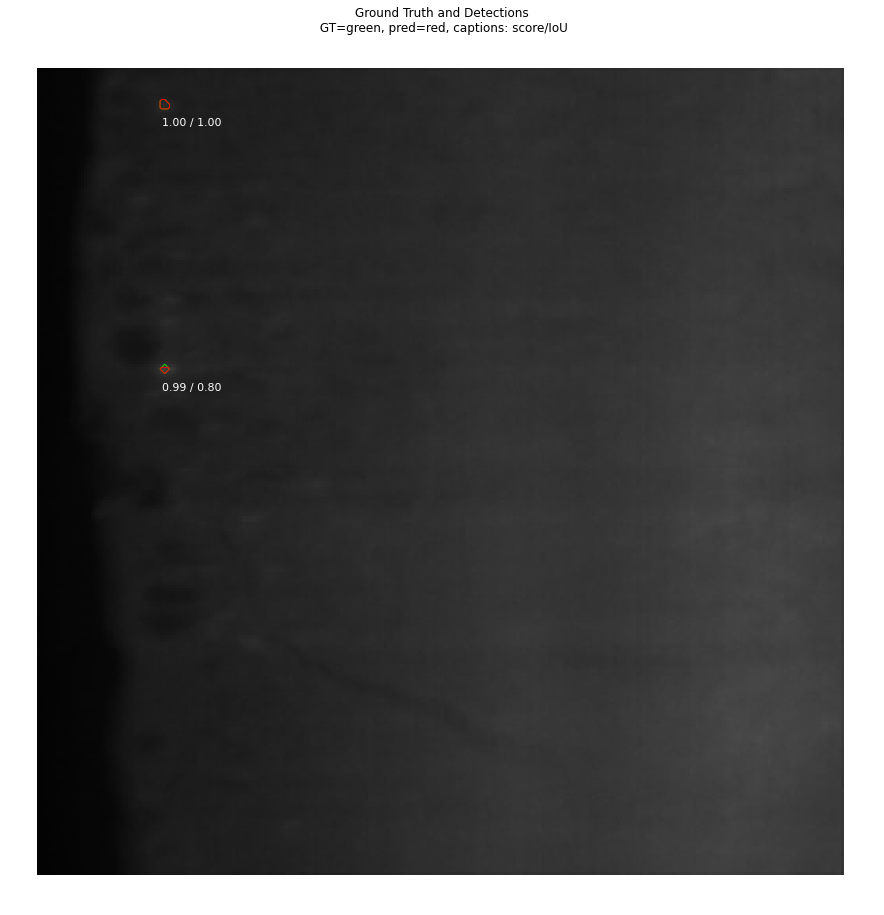

In [ ]:
from mrcnn.model import log
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

print(image.shape)
# Run object detection
results = model_inf.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

## Inspect the data

In [ ]:
# Load and display random samples
# ax = get_ax(rows=2, cols=2//2)
from skimage.transform import resize
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(6, 1, figsize=(20,50))
# print(len(set(dataset.image_ids)))
# print(dataset.image_ids)

config = NucleusConfig()
image_ids = np.random.choice(dataset.image_ids, 6)
# print(image_ids)
for i, image_id in enumerate(image_ids):
    print(image_id)
    image = dataset.load_image(image_id)
    # dataset.load_mask(image_id)
    # print(image)
    mask, class_ids = dataset.load_mask(image_id)

    # print(image.shape)
    # print(mask.shape)
    # mask = resize(mask, (224, 224,3), anti_aliasing=True)
    # visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

    # image = dataset.load_image(image_id)
    # mask_image, class_ids = dataset.load_mask(image_id)
    # print(mask_image)
    # visualize.display_top_masks(image, mask, class_ids, dataset.class_names, ax=ax[i, 1], limit=1)
    # print(mask_image.shape)
    # print(image.shape)
    # ax[i,0].imshow(image)
    # mask_image = resize(mask_image, (256, 256,3),
    #                    anti_aliasing=True)
    # ax[i,1].imshow(mask_image, cmap='gray')
    # print(mask_image.shape)

    # img, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    # visualize.display_instances(img, bbox, mask, class_ids, dataset.class_names,
    #                             show_bbox=True)
    # image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    #     dataset, config, image_id, use_mini_mask=False, augment=False)
    # visualize.display_instances(mask_image, bbox, mask, class_ids,
    #                             dataset.class_names, ax=ax[i,2],
    #                             show_mask=True, show_bbox=True)
    # break

132


AttributeError: ignored

## Dataset Stats


In [ ]:

def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 #  if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 2.8 seconds


In [ ]:
print(stats)
for s in stats:
  

[{'id': 0, 'shape': [224, 224, 3], 'bbox': [[3, 3], [2, 2], [3, 3]], 'color': array([68.42825255, 68.42825255, 68.42825255])}, {'id': 1, 'shape': [224, 224, 3], 'bbox': [[9, 8]], 'color': array([42.24039381, 42.24039381, 42.24039381])}, {'id': 2, 'shape': [224, 224, 3], 'bbox': [[2, 3], [2, 3]], 'color': array([31.0931521, 31.0931521, 31.0931521])}, {'id': 3, 'shape': [224, 224, 3], 'bbox': [[2, 2], [4, 3], [3, 6], [2, 1], [2, 2]], 'color': array([14.83368543, 14.83368543, 14.83368543])}, {'id': 4, 'shape': [224, 224, 3], 'bbox': [[2, 2], [2, 2], [2, 2], [2, 2]], 'color': array([20.51128029, 20.51128029, 20.51128029])}, {'id': 5, 'shape': [224, 224, 3], 'bbox': [[3, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 3], [2, 2], [2, 2]], 'color': array([24.06652583, 24.06652583, 24.06652583])}, {'id': 6, 'shape': [224, 224, 3], 'bbox': [[2, 2]], 'color': array([45.4666773, 45.4666773, 45.4666773])}, {'id': 7, 'shape': [224, 224, 3], 'bbox': [[3, 2], [3, 3], [2, 3], [4, 4], [3, 3], [3, 3], 

Image Count:  339
Height  mean: 224.00  median: 224.00  min: 224.00  max: 224.00
Width   mean: 224.00  median: 224.00  min: 224.00  max: 224.00
Color   mean (RGB): 35.98 35.98 35.98


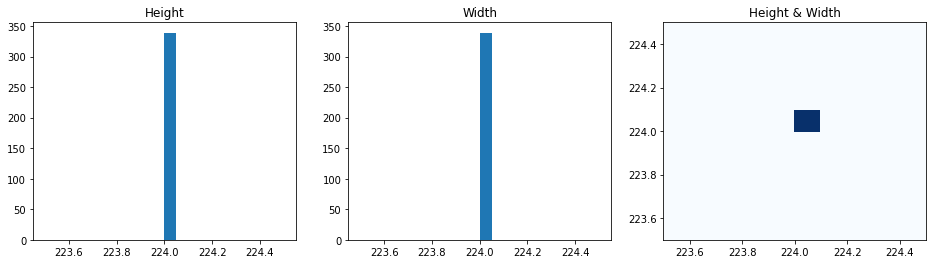

In [ ]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

Nuclei/Image
Image area <= 50.0**2: None
Image area <= 112.0**2: None
Image area <=  224**2:  mean: 4.7  median: 2.0  min: 1.0  max: 38.0


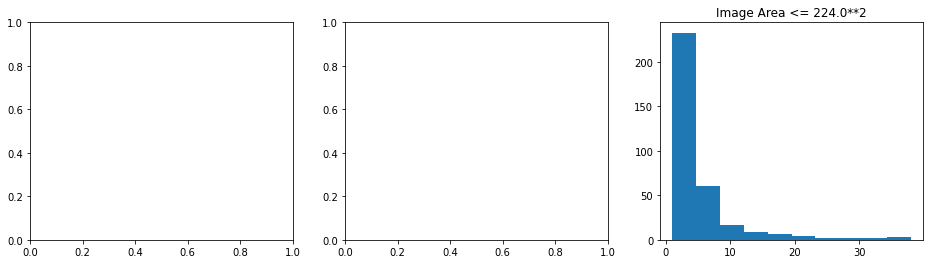

In [ ]:
# Segment by image area
image_area_bins = [50**2, 112**2, 224**2]

print("Nuclei/Image")
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    nuclei_per_image = np.array([len(s['bbox']) 
                                 for s in stats 
                                 if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area])
    area_threshold = image_area
    if len(nuclei_per_image) == 0:
        print("Image area <= {:4}**2: None".format(np.sqrt(image_area)))
        continue
    print("Image area <= {:4.0f}**2:  mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
        np.sqrt(image_area), nuclei_per_image.mean(), np.median(nuclei_per_image), 
        nuclei_per_image.min(), nuclei_per_image.max()))
    ax[i].set_title("Image Area <= {:4}**2".format(np.sqrt(image_area)))
    _ = ax[i].hist(nuclei_per_image, bins=10)

[]

Image Area <= 50**2
  Total Nuclei:  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # This is added back by InteractiveShellApp.init_path()


IndexError: ignored

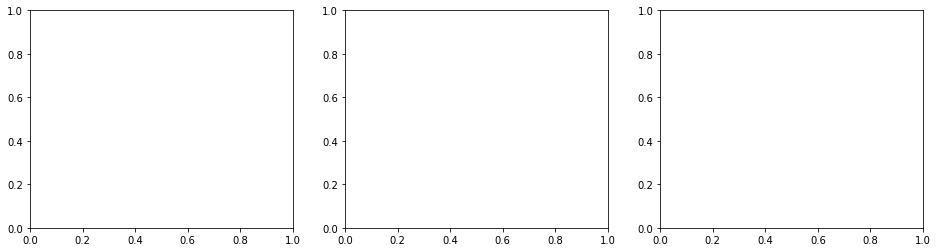

In [ ]:
# Nuclei size stats
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0

for i, image_area in enumerate(image_area_bins):
    nucleus_shape = np.array([
        b 
        for s in stats if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area
        for b in s['bbox']])
    print(nucleus_shape)
    if nucleus_shape:
      nucleus_area = nucleus_shape[:, 0] * nucleus_shape[:, 1]
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total Nuclei: ", nucleus_shape.shape[0])
    print("  Nucleus Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_shape[:, 0]), np.median(nucleus_shape[:, 0]),
        np.min(nucleus_shape[:, 0]), np.max(nucleus_shape[:, 0])))
    print("  Nucleus Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_shape[:, 1]), np.median(nucleus_shape[:, 1]),
        np.min(nucleus_shape[:, 1]), np.max(nucleus_shape[:, 1])))
    print("  Nucleus Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_area), np.median(nucleus_area),
        np.min(nucleus_area), np.max(nucleus_area)))

    # Show 2D histogram
    _ = ax[i].hist2d(nucleus_shape[:, 1], nucleus_shape[:, 0], bins=20, cmap="Blues")